In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.utils_contributions import *
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import json
import random
import numpy as np
random.seed(10)

from collections import defaultdict
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

In [4]:
from sklearn.metrics import jaccard_score
import math

methods_list = ['grad', 'ig_l2', 'ig_abs_mean', 'grad_input_l2', 'grad_input_mean_abs_mean', 'ours']
num_seeds = 10
results_corr = {}
bin = 0.25
similarity_method = 'corr' #corr/jaccard

for method in methods_list:
    np_results_corr = np.zeros((num_seeds,num_seeds))
    if method == 'pred_class':
        pass
    for seed_i in range(0,num_seeds):
        for seed_j in range(0,num_seeds):
            model1_file = f'./data/multiberts-seed_{seed_i}_sst2_attributions.npy'
            model2_file = f'./data/multiberts-seed_{seed_j}_sst2_attributions.npy'
            model1_data = np.load(model1_file,allow_pickle=True)[()]
            model2_data = np.load(model2_file,allow_pickle=True)[()]
            #results_corr[method] = []
            results_corr_tmp = []
            for i in range(1000):
                # Only check if both predictions are the same
                if model2_data['pred_class'][i] == model1_data['pred_class'][i]:
                    if similarity_method == 'corr':
                        # Spearman rank's correlation
                        model1_data_rank_ex = get_normalized_rank(np.asarray(model1_data[method][i]))
                        model2_data_rank_ex = get_normalized_rank(np.asarray(model2_data[method][i]))
                        sp = spearmanr(model1_data_rank_ex,model2_data_rank_ex)
                        results_corr_tmp.append(sp[0])
                    elif similarity_method == 'jaccard':
                        ## Jaccard similarity
                        model1_data_rank = list(get_rank(np.asarray(model1_data[method][i])))
                        model2_data_rank = list(get_rank(np.asarray(model2_data[method][i])))
                        order_index_rank_model1 = sorted(range(len(model1_data_rank)), key=lambda k: model1_data_rank[k],reverse=True)
                        order_index_rank_model2 = sorted(range(len(model2_data_rank)), key=lambda k: model2_data_rank[k],reverse=True)
                        sentence_len = len(order_index_rank_model1)
                        top_k = math.ceil(sentence_len*bin)
                        a = order_index_rank_model1[:top_k]
                        b = order_index_rank_model2[:top_k]
                        sp = jaccard_similarity(a, b)
                        results_corr_tmp.append(sp)
            print('seed_i', seed_i)
            print('seed_j', seed_j)
            np_results_corr[seed_i,seed_j] = np.mean(results_corr_tmp)
    results_corr[method] = np_results_corr
    if similarity_method == 'corr':
        # Save correlation values
        outfile = f'./data/{similarity_method}.npy'
        np.save(outfile,results_corr)
    else:
        # Save jaccard values
        outfile = f'./data/{similarity_method}_{25}.npy'
        np.save(outfile,results_corr)


seed_i 0
seed_j 0
seed_i 0
seed_j 1
seed_i 0
seed_j 2
seed_i 0
seed_j 3
seed_i 0
seed_j 4
seed_i 0
seed_j 5
seed_i 0
seed_j 6
seed_i 0
seed_j 7
seed_i 0
seed_j 8
seed_i 0
seed_j 9
seed_i 1
seed_j 0
seed_i 1
seed_j 1
seed_i 1
seed_j 2
seed_i 1
seed_j 3
seed_i 1
seed_j 4
seed_i 1
seed_j 5
seed_i 1
seed_j 6
seed_i 1
seed_j 7
seed_i 1
seed_j 8
seed_i 1
seed_j 9
seed_i 2
seed_j 0
seed_i 2
seed_j 1
seed_i 2
seed_j 2
seed_i 2
seed_j 3
seed_i 2
seed_j 4
seed_i 2
seed_j 5
seed_i 2
seed_j 6
seed_i 2
seed_j 7
seed_i 2
seed_j 8
seed_i 2
seed_j 9
seed_i 3
seed_j 0
seed_i 3
seed_j 1
seed_i 3
seed_j 2
seed_i 3
seed_j 3
seed_i 3
seed_j 4
seed_i 3
seed_j 5
seed_i 3
seed_j 6
seed_i 3
seed_j 7
seed_i 3
seed_j 8
seed_i 3
seed_j 9
seed_i 4
seed_j 0
seed_i 4
seed_j 1
seed_i 4
seed_j 2
seed_i 4
seed_j 3
seed_i 4
seed_j 4
seed_i 4
seed_j 5
seed_i 4
seed_j 6
seed_i 4
seed_j 7
seed_i 4
seed_j 8
seed_i 4
seed_j 9
seed_i 5
seed_j 0
seed_i 5
seed_j 1
seed_i 5
seed_j 2
seed_i 5
seed_j 3
seed_i 5
seed_j 4
seed_i 5
s

### Load data similarity method

In [6]:
similarity_file = f'./data/{similarity_method}.npy'
results_corr = np.load(similarity_file,allow_pickle=True)[()]

In [7]:
results_corr_flatten = {}
for method in results_corr.keys():
    res_method = results_corr[method]
    # Extract the diagonal and flatten
    flatten_similarity = res_method[~np.eye(res_method.shape[0],dtype=bool)].reshape(res_method.shape[0],-1).flatten()
    results_corr_flatten[method] = flatten_similarity

PathPatch6((0.75, 0.713552) ...)
PathPatch6((1.75, 0.620015) ...)
PathPatch6((2.75, 0.706199) ...)
PathPatch6((3.75, 0.651396) ...)
PathPatch6((4.75, 0.789026) ...)
PathPatch6((5.75, 0.903127) ...)


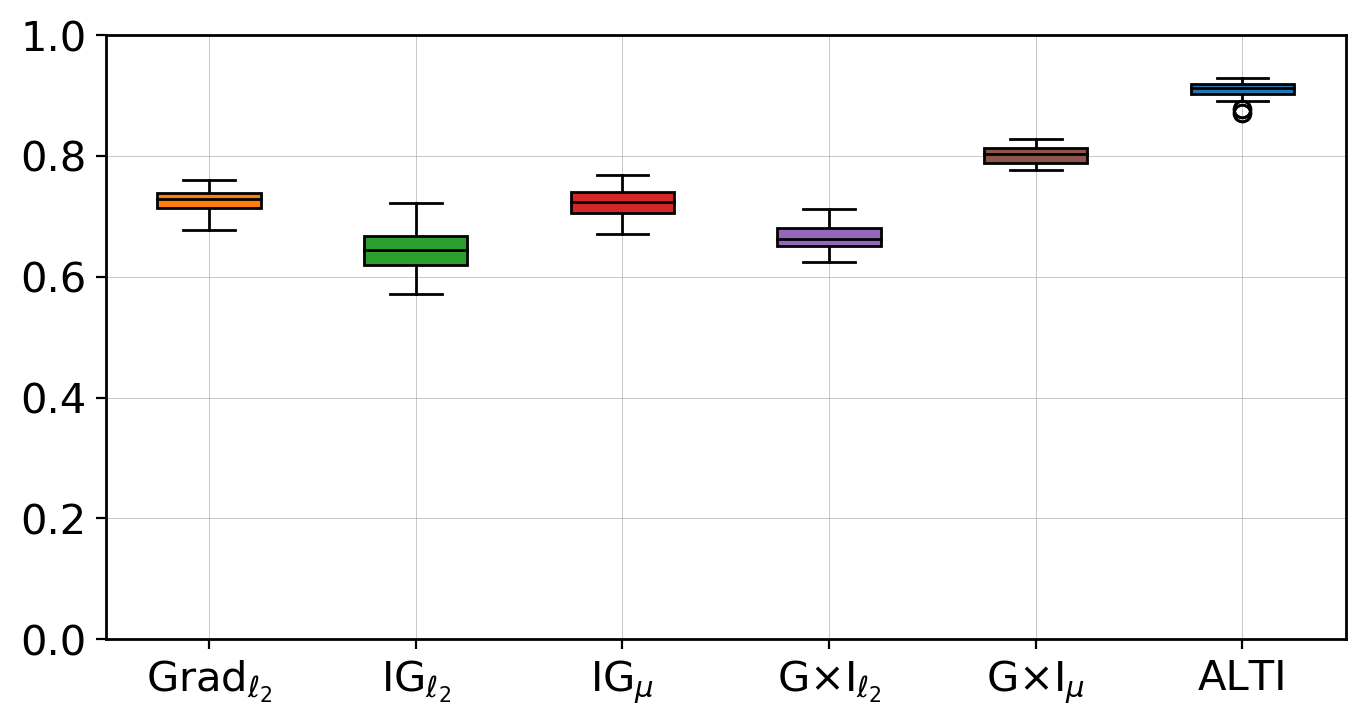

In [8]:
index= []
data = []

color_lines = {'ours': '#1f77b4',
                'grad': '#ff7f0e',
                'ig_l2': '#2ca02c',
                'ig_abs_mean': '#d62728',
                'grad_input_l2': '#9467bd',
                'grad_input_mean_abs_mean': '#8c564b',
                'rollout': '#e377c2',
                'norm2': '#7f7f7f',
                'ours2': '#bcbd22'}

method_labels_dict = {'ours': 'ALTI', 'ours2': 'ALTI (+ LN2)', 'ours3': 'ALTI FULL', 'grad':r'Grad$_{\ell_2}$', 'grad_input_abs': 'Grad input',
                         'grad_input_clip': 'Gradxinput (clip)', 'grad_input_l2' : r'G$\times$I$_{\ell_2}$',
                         'grad_input_mean' : r'G$\times$I$_{\mu}$no abs',
                         'grad_input_mean_abs_mean': r'G$\times$I$_{\mu}$', 'ig_abs': 'IG (abs)',
                         'ig_clip': 'IG (clip)', 'ig_l2':r'IG$_{\ell_2}$', 'ig_mean': 'IG$_{\mu} no abs$',
                         'ig_abs_mean': 'IG$_{\mu}$', 'norm': 'Norm Rollout', 'norm2': 'Globenc', 'rollout': 'Rollout',
                         'blankout': 'blankout'}

for i, (key, val) in enumerate(results_corr_flatten.items()):
    index.append(method_labels_dict[key])
    data.append(val)
fig, ax = plt.subplots(figsize =(8, 4),dpi=200)
box = ax.boxplot(data, patch_artist=True)
plt.setp(box['medians'], color='black')
for i, patch in enumerate(box['boxes']):
    print(patch)
    patch.set_facecolor(color_lines[list(results_corr_flatten.keys())[i]])
ax.set_xticklabels(index)
ax.set_ylim(0,1)
plt.grid(False, linewidth=0.25)# linestyle=(0, (5, 10))
plt.show();

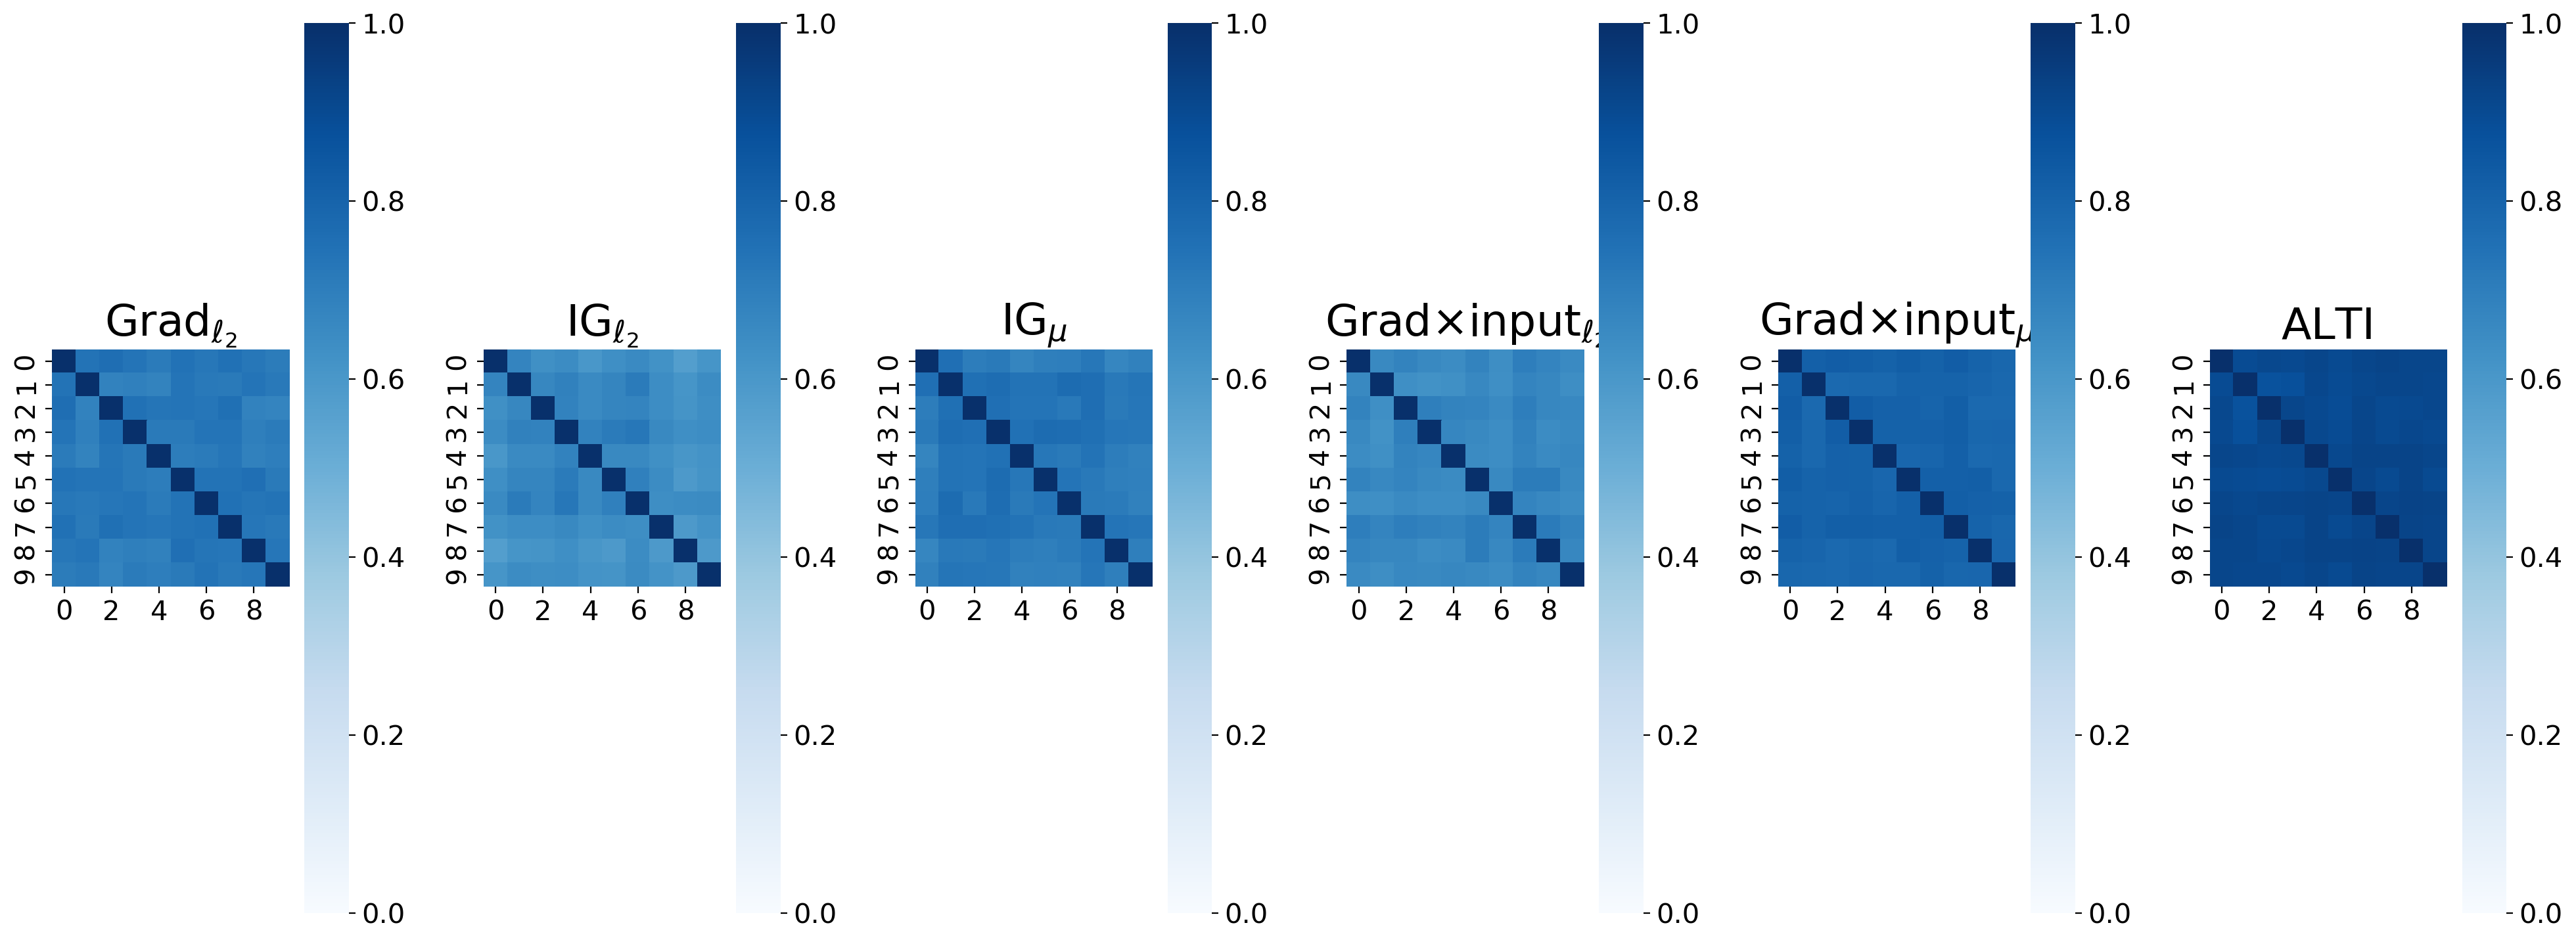

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

In [47]:
method_labels_dict = {'ours': 'ALTI', 'ours2': 'ALTI (+ LN2)', 'ours3': 'ALTI FULL', 'grad':r'Grad$_{\ell_2}$', 'grad_input_abs': 'Grad input',
                         'grad_input_clip': 'Gradxinput (clip)', 'grad_input_l2' : r'Grad$\times$input$_{\ell_2}$',
                         'grad_input_mean' : r'Grad$\times$input$_{\mu}$no abs',
                         'grad_input_mean_abs_mean': r'Grad$\times$input$_{\mu}$', 'ig_abs': 'IG (abs)',
                         'ig_clip': 'IG (clip)', 'ig_l2':r'IG$_{\ell_2}$', 'ig_mean': 'IG$_{\mu} no abs$',
                         'ig_abs_mean': 'IG$_{\mu}$', 'norm': 'Norm Rollout', 'norm2': 'Globenc', 'rollout': 'Rollout',
                         'blankout': 'blankout'}

row = 1
col = len(methods_list)
fig, axs = plt.subplots(row, col,figsize=(20,13), dpi=200,sharey=False)


for i, method in enumerate(methods_list):
    plt.figure(figsize=(6,6))
    df = pd.DataFrame(results_corr[method])
    sns.heatmap(df,cmap="Blues",square=True,vmin=0,ax=axs[i])
    axs[i].set_title(method_labels_dict[method])

fig.tight_layout();